In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter


In [78]:
# Define base directory relative to the notebook
BASE_DIR = os.getcwd()  # Gets the current working directory

csv_file_path = os.path.join(BASE_DIR, "execution_results.csv")
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")


# Load execution results CSV
df = pd.read_csv(csv_file_path)

In [79]:


# Load the execution results CSV file
execution_results = pd.read_csv(csv_file_path)

# Extract only the file names from the "R/Rmd Script" column
execution_results["R/Rmd Script"] = execution_results["R/Rmd Script"].apply(lambda x: os.path.basename(str(x)))

# Save the cleaned CSV filee
cleaned_csv_path = "execution_results_cleaned.csv"
execution_results.to_csv(cleaned_csv_path, index=False)



In [80]:
# Identify and remove duplicate entries based on "Project ID" and "R/Rmd Script"
execution_results_no_duplicates = execution_results.drop_duplicates(subset=["Project ID", "R/Rmd Script"], keep="first")

execution_results_no_duplicates.to_csv(cleaned_csv_path, index=False)

In [89]:
import os
import re
import pandas as pd

# Define paths
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")  # Path to merged log file
output_csv = os.path.join(BASE_DIR, "execution_issues.csv")  # Output CSV file

# Define error categorization keywords
code_error_keywords = [
    "does not exist", "unexpected", "cannot change working directory",
    "file choice cancelled", "invalid argument"
]
container_error_keywords = [
    "unable to load shared object", "cannot open shared object file",
    "no package called", "lazy loading failed", "package or namespace load failed",
    "package installation failed", "missing package"
]

# Combined pattern for "error in file" and "cannot open the connection"
combined_error_pattern = r"error in file.*?: cannot open the connection"

# Common error types (shorter classification)
error_patterns = {
    combined_error_pattern: "File Read Error - Cannot Open Connection",  # Unified pattern
    r"cannot change working directory": "Directory Change Failure",
    r"does not exist": "Object or File Missing",
    r"unexpected": "Syntax Error",
    r"file choice cancelled": "File Selection Error",
    r"invalid argument": "Invalid Function Argument",
    r"unable to load shared object": "Shared Library Not Found",
    r"lazy loading failed": "Package Loading Issue",
    r"package or namespace load failed": "Package Loading Failed",
    r"no package called ‘([^’]+)’": "Missing Package",
}

# Regex patterns for log parsing
project_pattern = re.compile(r"=== Project (\w+) Execution Log ===")
r_script_pattern = re.compile(r"File: (.+\.R)")
error_pattern = re.compile(r"Execution Failed:\n(.*?)\nExecution halted", re.DOTALL)
success_pattern = re.compile(r"Execution Successful:")

# List to store extracted information
execution_issues = []

# Variables to track the current project and script
current_project = None
current_script = None
executed_scripts = set()  # Store executed script names to avoid duplication

# Read log file and extract information
with open(log_file_path, "r", encoding="utf-8") as file:
    log_data = file.read().split("========================================")

for section in log_data:
    project_match = project_pattern.search(section)
    script_match = r_script_pattern.search(section)
    error_match = error_pattern.search(section)
    success_match = success_pattern.search(section)

    if project_match:
        current_project = project_match.group(1)

    if script_match:
        current_script = os.path.basename(script_match.group(1))

    if current_project and current_script:
        if error_match:
            error_message = error_match.group(1).strip()
            short_error = "Unknown Error"

            # Categorize error
            if re.search(combined_error_pattern, error_message, re.IGNORECASE):
                reason = "Container Issue"
                short_error = "File Read Error - Cannot Open Connection"
            elif any(keyword in error_message.lower() for keyword in container_error_keywords):
                reason = "Container Issue"
                short_error = "Containerization Failure"
            elif any(keyword in error_message.lower() for keyword in code_error_keywords):
                reason = "Code Issue"
            else:
                reason = "Code Issue"  # Default classification

            # Assign a short error description based on patterns
            for pattern, short_desc in error_patterns.items():
                if re.search(pattern, error_message, re.IGNORECASE):
                    short_error = short_desc
                    break

            # Append failed execution details
            execution_issues.append([current_project, current_script, "Failed", reason, short_error])
            executed_scripts.add((current_project, current_script))  # Track the script

        elif success_match:
            # Append successful execution details
            execution_issues.append([current_project, current_script, "Success", "-", "-"])
            executed_scripts.add((current_project, current_script))  # Track the script

# Remove projects that have no executed scripts
df_execution_issues = pd.DataFrame(
    execution_issues, columns=["Project ID", "File Name", "Execution Status", "Reason", "Error Message"]
).drop_duplicates()

# Save to a single CSV file
df_execution_issues.to_csv(output_csv, index=False)

print("✅ Categorization complete! The following file has been generated:")
print(f"- {output_csv} (Consolidated execution issues)")


✅ Categorization complete! The following file has been generated:
- /Users/fury/execution_issues.csv (Consolidated execution issues)


In [90]:
import os
import re
import pandas as pd

# Define log file path
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")  # Adjust BASE_DIR accordingly

# Regex patterns to extract project ID and script file names
project_pattern = re.compile(r"=== Project (\w+) Execution Log ===")
r_script_pattern = re.compile(r"File: (.+\.R)")

# Dictionary to store unique R scripts per project
project_scripts = {}

# Variables to track the current project
current_project = None

# Read log file and extract information
with open(log_file_path, "r", encoding="utf-8") as file:
    for line in file:
        project_match = project_pattern.search(line)
        script_match = r_script_pattern.search(line)

        if project_match:
            current_project = project_match.group(1)
            if current_project not in project_scripts:
                project_scripts[current_project] = set()

        if script_match and current_project:
            script_name = os.path.basename(script_match.group(1))
            project_scripts[current_project].add(script_name)  # Store unique script names per project

# Flatten dictionary to rows and remove projects with no scripts
execution_data = [
    (project, script) 
    for project, scripts in project_scripts.items() 
    for script in sorted(scripts)
]

# Convert to DataFrame
df_script_list = pd.DataFrame(execution_data, columns=["Project ID", "Executed R Script"])

# Save to CSV (optional)
output_csv = os.path.join(BASE_DIR, "r_script_execution_list.csv")
df_script_list.to_csv(output_csv, index=False)

print(f"✅ Extracted R script filenames for each project.")
print(f"- Details saved in {output_csv}")


✅ Extracted R script filenames for each project.
- Details saved in /Users/fury/r_script_execution_list.csv


In [78]:

txt_file_path = os.path.join(BASE_DIR, "project_ids.txt")  # Project IDs from text file

with open(txt_file_path, "r") as file:
    txt_project_ids = {line.strip() for line in file if line.strip()}  # Use a set for quick lookup

print(f"Found {len(txt_project_ids)} project IDs in '{txt_file_path}'")

df = pd.read_csv(csv_file_path)

if "Project ID" not in df.columns:
    raise ValueError("'Project ID' column is missing in the CSV!")

csv_project_ids = set(df["Project ID"].astype(str).unique())  # Convert all to string for consistency

print(f"Found {len(csv_project_ids)} unique project IDs in '{csv_file_path}'")


Found 296 project IDs in '/Users/fury/project_ids.txt'
Found 253 unique project IDs in '/Users/fury/execution_results.csv'


In [79]:

missing_projects = txt_project_ids - csv_project_ids  # IDs in TXT but not in CSV
# Display Results
if missing_projects:
    print(f"⚠️ {len(missing_projects)} projects are missing from the CSV:")
    print("\n".join(missing_projects))
else:
    print("✅ All project IDs from the text file exist in the CSV!")

⚠️ 43 projects are missing from the CSV:
qsa5w
dkrhy
82dqk
9vr6q
9gq4a
b7krz
9jzfr
m72gb
kpe75
egpr5
dhmjx
jpxts
4ya6x
8fsbd
xuz8d
wyrav
u3wby
6krj7
mj5nh
9vn68
gwn4y
akywf
p46mb
pnug5
srbcf
ha4q8
3aryn
y5gr9
a6tuw
fdp39
vy763
yhmbd
qjfv4
a8htx
3uyjt
ajf3h
amd3r
hu2n8
zh3f4
hfy4k
dh32q
b5ydr
975k3


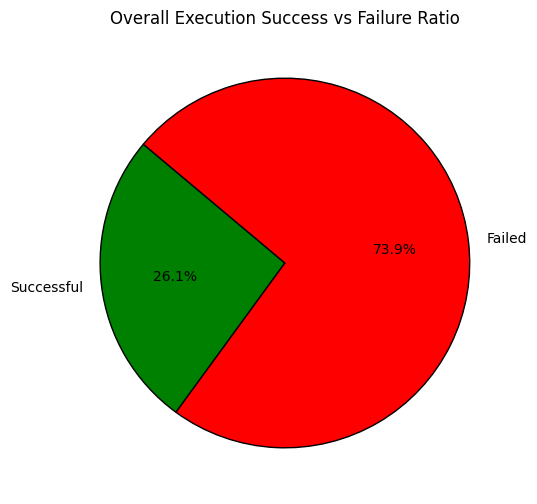

In [83]:
# Reload the execution results CSV file

execution_results = pd.read_csv(cleaned_csv_path)

# Count the total number of successful and failed executions
success_fail_count = execution_results.groupby(["Project ID", "Execution Status"]).size().unstack(fill_value=0)

# Compute total successful and failed executions across all projects
total_successful = success_fail_count.get("Successful", 0).sum()
total_failed = success_fail_count.get("Failed", 0).sum()


# Alternative Visualization 2: Pie Chart for Overall Success vs Failure
fig, ax = plt.subplots(figsize=(6, 6))
plt.pie([total_successful, total_failed], labels=["Successful", "Failed"], autopct='%1.1f%%', colors=["green", "red"], startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Overall Execution Success vs Failure Ratio")
plt.show()


# Display total counts
total_counts_df = pd.DataFrame({"Execution Status": ["Successful", "Failed"], "Total Count": [total_successful, total_failed]})



In [84]:
#total_errors = error_df["Successful"].sum()
print(f"🔍 Total number of errors: {total_counts_df}")

🔍 Total number of errors:   Execution Status  Total Count
0       Successful          121
1           Failed          343


In [91]:
import pandas as pd

# Define relative paths
project_id_file_path = "project_id_r_code_file.csv"
execution_results_file_path = "execution_issues.csv"
updated_project_file_path = "updated_project_id_r_code_file.csv"


# Load the CSV files
df_project = pd.read_csv(project_id_file_path)
df_execution = pd.read_csv(execution_results_file_path)

# Print column names
print("Columns in df_project:", df_project.columns)
print("Columns in df_execution:", df_execution.columns)



Columns in df_project: Index(['Project ID', 'R Code File'], dtype='object')
Columns in df_execution: Index(['Project ID', 'File Name', 'Execution Status', 'Reason',
       'Error Message'],
      dtype='object')


In [92]:
df_merged = df_project.merge(
    df_execution,
    left_on=["Project ID", "R Code File"],
    right_on=["Project ID", "File Name"],  # Adjust column name if needed
    how="left"
)


In [93]:
# Drop redundant column if it exists
if "File Name" in df_merged.columns:
    df_merged = df_merged.drop(columns=["File Name"])

# Save the updated file
df_merged.to_csv("updated_project_id_r_code_file.csv", index=False)

print("✅ Merge complete! Updated file saved.")


✅ Merge complete! Updated file saved.


In [95]:
import pandas as pd
import os

# Define relative file paths (assuming CSVs are in the 'data' folder in the notebook directory)
statcodesearch_file_path = "statcodesearch_pckg_urls (1).csv"
updated_project_file_path = "updated_project_id_r_code_file.csv"
output_file_path = "updated_statcodesearch.csv"

# Load both CSV files
df_statcodesearch = pd.read_csv(statcodesearch_file_path)
df_updated_project = pd.read_csv(updated_project_file_path)

# Extract Project ID from the Source column (last part of the URL)
df_statcodesearch["Project ID"] = df_statcodesearch["Source"].str.extract(r'\/([a-zA-Z0-9]+)\/?$')

# Normalize the Idx column by removing extra numbers before and after the file name
df_statcodesearch["Normalized R Code File"] = df_statcodesearch["Idx"].str.replace(r'^\d+\s+|\s+\d+$', '', regex=True)

# Merge execution status from updated_project file based on Project ID and R Code File
df_statcodesearch = df_statcodesearch.merge(
    df_updated_project[["Project ID", "R Code File", "Execution Status", "Reason", "Error Message"]],
    left_on=["Project ID", "Normalized R Code File"],
    right_on=["Project ID", "R Code File"],
    how="left"
)

# Drop redundant "R Code File" column
df_statcodesearch.drop(columns=["R Code File"], inplace=True)

# Save the updated file
df_statcodesearch.to_csv(output_file_path, index=False)

# Display the updated DataFrame
df_statcodesearch.head()


,Idx,Comment,Code,License,Label,Author,Datasets,Packages,Packages URL,Output Types,...,Project description,Domain,Publication date,Date modified,DOI,Project ID,Normalized R Code File,Execution Status,Reason,Error Message
0,10222 pupillometry_tutorial_calignano.R 0,exclude NAs from data,"data <- data[complete.cases(data$average), ] s...",CC0 1.0 Universal,Data Variable,Giulia Calignano,['dataset_tutorial.csv'],"['dplyr', 'naniar', 'plyr', 'plyr', 'mgcv', 'i...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,Here you will find all the materials of the tu...,Psychology,2022-10-24,2023-05-25,10.17605/OSF.IO/QHAF8,qhaf8,pupillometry_tutorial_calignano.R,Failed,Code Issue,Directory Change Failure
1,9088 Social Factors COVID-19_Konrad.R 18,"2. compare model indices (ICC, conditional an...","tab_model(model0.1, model1, model1_full) tab_m...",CC-By Attribution 4.0 International,Statistical Modeling,Annika Konrad,['data_Konrad_etal.csv'],"['compareGroups', 'psych', 'lme4', 'emmeans', ...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,We aimed to predict psychological distress ove...,Social Science,2021-05-04,2022-07-13,NaN,8edp7,Social Factors COVID-19_Konrad.R,Failed,Code Issue,Invalid Function Argument
2,9088 Social Factors COVID-19_Konrad.R 21,Plot robust model 1 get predicted Values for ...,"gg_model1 <- ggpredict(model1_robust, c(""dayco...",CC-By Attribution 4.0 International,Visualization,Annika Konrad,['data_Konrad_etal.csv'],"['compareGroups', 'psych', 'lme4', 'emmeans', ...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,We aimed to predict psychological distress ove...,Social Science,2021-05-04,2022-07-13,NaN,8edp7,Social Factors COVID-19_Konrad.R,Failed,Code Issue,Invalid Function Argument
3,10940 AnalysisPost-PAP.R 11,count of articles that generated data using ex...,"GenerateData[2,2] <- sum(MMCPSR_emp$EHPdata) G...",Other,Data Variable,Daniel Solomon,NaN,"['viridis', 'forcats', 'ggstance']","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,This project surveys the conduct of political ...,Psychology,2021-09-23,2023-05-12,NaN,uhma8,AnalysisPost-PAP.R,NaN,NaN,NaN
4,5080 SRMA2019_analyses.R 0,Data organization Rename columns/variable na...,colnames(srmadata) srmadata <- srmadata %>% re...,CC-By Attribution 4.0 International,Data Variable,Daniel Umpierre,['SRMAdata.csv'],"['tidyverse', 'DescTools', 'ggplot2']","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,The SEES-Initiative generates prospective and ...,Social Science,2019-03-06,2022-12-02,10.17605/OSF.IO/NTW7D,ntw7d,SRMA2019_analyses.R,Failed,Code Issue,Unknown Error
